In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
import omicverse as ov
from omicverse.utils import mde
import scanpy as sc
import scvelo as scv
ov.utils.ov_plot_set()

In [3]:
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [ ]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)
adata

In [ ]:
adata=adata[:,adata.var['highly_variable_features']==True]
adata

In [4]:
import numpy as np
import pandas as pd
bulk=pd.read_csv('data/GSE74985_mergedCount.txt.gz',index_col=0,sep='\t')
bulk=ov.bulk.Matrix_ID_mapping(bulk,'genesets/pair_GRCm39.tsv')
bulk.head()

,dg_d_1,dg_d_2,dg_d_3,dg_v_1,dg_v_2,dg_v_3,ca4_1,ca4_2,ca4_3,ca3_d_1,...,ca3_v_3,ca2_1,ca2_2,ca2_3,ca1_d_1,ca1_d_2,ca1_d_3,ca1_v_1,ca1_v_2,ca1_v_3
Miga1,298,364,634,1356,1311,1902,2536,2299,2285,1879,...,3702,2376,2583,3425,3783,3478,2946,924,567,1227
Hunk,2,6,29,36,36,98,1398,2157,887,552,...,1481,2512,2440,2469,3279,3348,2576,426,233,279
Sult2a-ps3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Smg6,453,406,352,978,468,659,723,767,611,629,...,932,506,597,537,779,914,640,207,215,388
Chmp5,122,132,95,645,857,667,1130,1007,852,633,...,1574,605,799,659,870,1452,970,171,160,356


In [5]:
bulktb=ov.bulk2single.BulkTrajBlend(bulk_seq=bulk,single_seq=adata,
                                    bulk_group=['dg_d_1','dg_d_2','dg_d_3'],
                                    celltype_key='clusters',)
#bulktb.bulk_preprocess_lazy()
#bulktb.single_preprocess_lazy()

In [6]:
bulktb.vae_configure(cell_target_num=200)

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


In [7]:
features=bulktb.vae_model.input_data['input_sc_data'].T
labels=bulktb.vae_model.input_data['input_sc_meta']['Cell_type'].astype('str')

# 将类别字符串映射为数字编码
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
labels_encoded = labels.map(label_mapping)

# 转换为 PyTorch 张量
features_tensor = torch.Tensor(features.values)
labels_tensor = torch.LongTensor(labels_encoded.values)  # 使用 LongTensor 存储整数标签


In [8]:
# 创建 DataLoader（如果需要）
# DataLoader 可以帮助你批量加载数据，方便训练
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [9]:
n_epochs=200
batch_size=64
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
n_classes=len(list(set(labels)))  # 类别数量
img_size=features.shape[1]
channels=1
sample_interval=400
n_features=features.shape[1]

In [10]:
cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm1d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes,n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, n_features),
            #nn.Sigmoid()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        #img = img.view(img.size(0), *img_shape)
        return img

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Linear(512, 1),
        )
        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(512, n_classes), nn.Softmax())

    def forward(self, img):
        # Concatenate label embedding and image to produce input
        #d_in = torch.cat((img, self.label_embedding(labels)), -1)
        out=self.model(img)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity,label

In [13]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

In [14]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (label_embedding): Embedding(14, 14)
  (model): Sequential(
    (0): Linear(in_features=12953, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (aux_layer): Sequential(
    (0): Linear(in_features=512, out_features=14, bias=True)
    (1): Softmax(dim=None)
  )
)

In [15]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [16]:

# ----------
#  Training
# ----------
from tqdm import trange,tqdm

n_epochs=3000
latent_dim=100

bar = tqdm(range(n_epochs))
d_loss_li=[]
g_loss_li=[]
d_acc_li=[]

d_r_acc_li=[]
d_f_acc_li=[]
d_acc_max=0

for epoch in bar:
    for i, (imgs, labels) in enumerate(data_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        real_pred=real_aux.data.cpu().numpy()
        fake_pred=fake_aux.data.cpu().numpy()
        real_gt=labels.data.cpu().numpy()
        fake_gt=gen_labels.data.cpu().numpy()
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)
        real_acc=np.mean(np.argmax(real_pred, axis=1) == real_gt)
        fake_acc=np.mean(np.argmax(fake_pred, axis=1) == fake_gt)

        d_loss.backward()
        optimizer_D.step()
    
    if d_acc>=d_acc_max:
        import pickle
        with open('result/acgan_dg_generator.pkl','wb') as f:
            pickle.dump(generator,f)
        with open('result/acgan_dg_discriminator.pkl','wb') as f:
            pickle.dump(discriminator,f)
        d_acc_max=d_acc
        


    bar.set_description(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%, real_acc: %d%%, fake_acc: %d%%] [G loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), d_loss.item(), 100 * d_acc, 100*real_acc,100*fake_acc,g_loss.item())
        )
    d_loss_li.append(d_loss.item())
    g_loss_li.append(g_loss.item())
    d_acc_li.append(100*d_acc)
    d_r_acc_li.append(100*real_acc)
    d_f_acc_li.append(100*fake_acc)

[Epoch 2999/3000] [Batch 45/46] [D loss: 0.887753, acc: 99%, real_acc: 100%, fake_acc: 98%] [G loss: 6.328508]: 100%|██████████| 3000/3000 [20:20<00:00,  2.46it/s]   


In [17]:
with open('result/acgan_dg_generator.pkl','rb') as f:
    generator=pickle.load(f)
    
with open('result/acgan_dg_discriminator.pkl','rb') as f:
    discriminator=pickle.load(f)

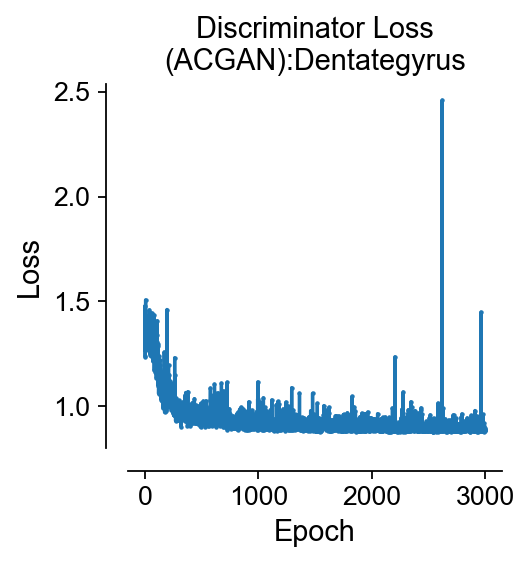

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(range(len(d_loss_li)),d_loss_li,s=1)
ax.plot(range(len(d_loss_li)),d_loss_li)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Discriminator Loss\n(ACGAN):Dentategyrus',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_d_acgan_dg.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_d_acgan_dg.pdf',dpi=300,bbox_inches='tight')


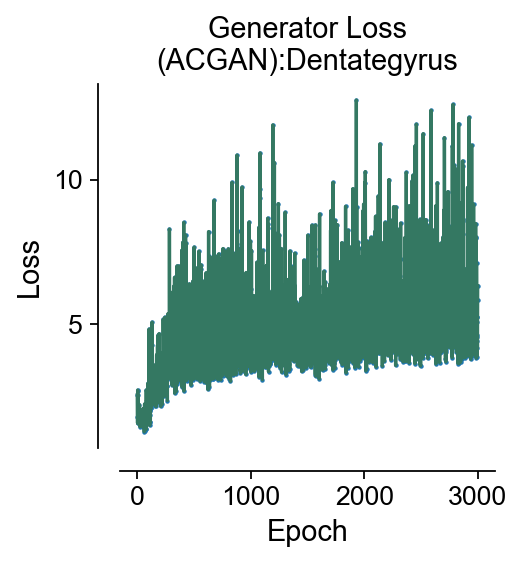

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(range(len(g_loss_li)),g_loss_li,s=1)
ax.plot(range(len(g_loss_li)),g_loss_li,color=ov.utils.blue_color[0])

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Generator Loss\n(ACGAN):Dentategyrus',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_g_acgan_dg.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_g_acgan_dg.pdf',dpi=300,bbox_inches='tight')


In [20]:
Variable(FloatTensor(np.random.normal(0, 1, (100, latent_dim)))).shape

torch.Size([100, 100])

In [21]:
n_row=14
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row * 100, latent_dim))))
# Get labels ranging from 0 to n_classes for n rows
labels = np.array([num for _ in range(100) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)

In [22]:
gen_imgs.max()

tensor(7.6369, device='cuda:0', grad_fn=<MaxBackward1>)

In [23]:
gen_imgs.min()

tensor(-3.1579, device='cuda:0', grad_fn=<MinBackward1>)

In [24]:


import anndata
test_adata=anndata.AnnData(np.array(gen_imgs.cpu().detach().numpy()))
rev_dict=dict(zip(label_mapping.values(),label_mapping.keys()))
test_adata.obs['celltype_num']=labels.cpu().detach().numpy()
test_adata.obs['celltype']=test_adata.obs['celltype_num'].map(rev_dict)


In [25]:
test_adata.layers['scaled']=test_adata.X.copy()
ov.pp.pca(test_adata,layer='scaled',n_pcs=50)
test_adata

AnnData object with n_obs × n_vars = 1400 × 12953
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [26]:
test_adata.obsm["X_mde"] = ov.utils.mde(test_adata.obsm["scaled|original|X_pca"])
test_adata

AnnData object with n_obs × n_vars = 1400 × 12953
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [28]:
test_adata.var.index=features.columns

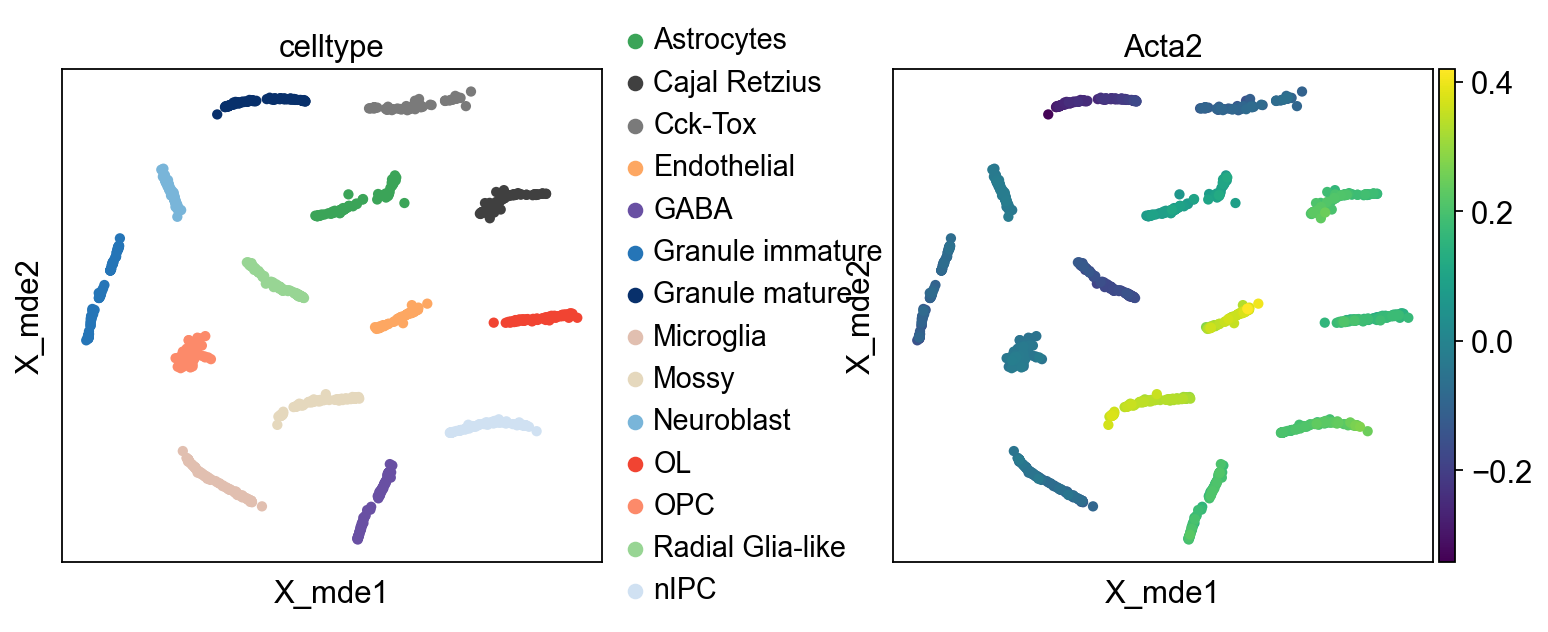

In [30]:
sc.pl.embedding(test_adata,
                basis='X_mde',
           color=['celltype','Acta2'],
           wspace=0.4,palette=adata.uns['clusters_colors'].tolist())

In [31]:
adata.obs['celltype']=adata.obs['clusters'].copy()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


(<Figure size 480x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'Expression correlation'}, xlabel='scRNA-seq reference', ylabel='deconvoluted bulk-seq'>)

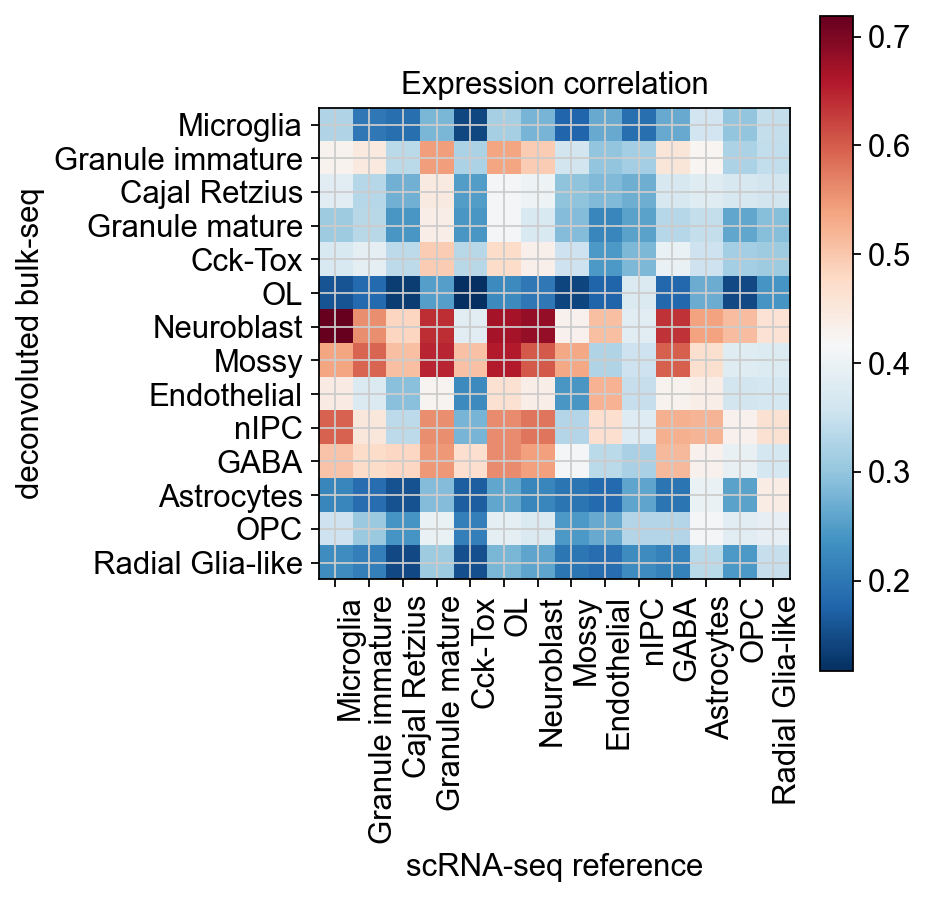

In [30]:
ov.bulk2single.bulk2single_plot_correlation(adata,test_adata,celltype_key='celltype')

In [35]:
adata_t=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)

Begin robust gene identification
After filtration, 13264/13264 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [36]:
cor_pd=ov.bulk2single.bulk2single_plot_correlation(adata_t,test_adata,celltype_key='celltype',
                                           return_table=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [38]:
#sc.tl.rank_genes_groups(single_data, celltype_key, method='wilcoxon')
marker_df = pd.DataFrame(adata_t.uns['rank_genes_groups']['names']).head(200)
#marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(generate_adata.var.index.tolist()))
marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(test_adata.var.index.tolist()))

# the mean expression of 200 marker genes of input sc data
sc_marker = adata_t[:,marker].to_df()
sc_marker['celltype'] = adata_t.obs['celltype']
sc_marker_mean = sc_marker.groupby('celltype')[marker].mean()

In [39]:
sc_marker_mean=sc_marker_mean.T

In [40]:
rf_ct = list(sc_marker_mean.columns)

In [41]:
cor_pd=pd.DataFrame(cor_pd,
                   index=rf_ct,
                   columns=rf_ct)

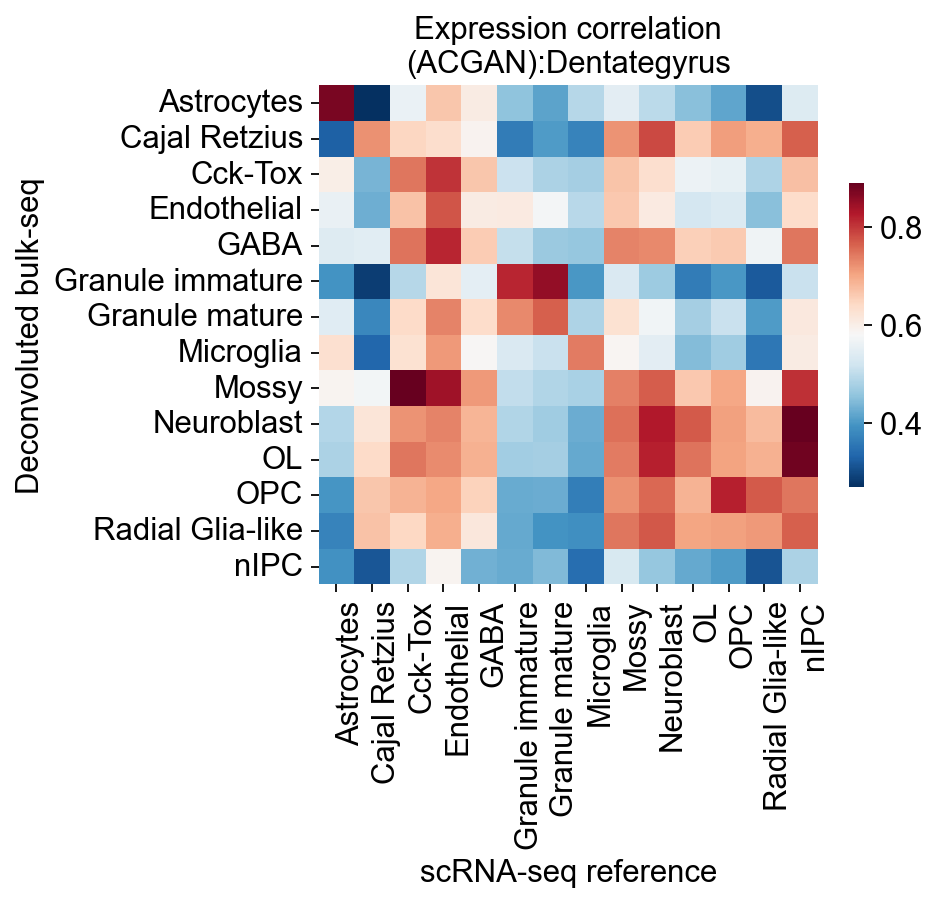

In [43]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cor_pd,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Expression correlation\n(ACGAN):Dentategyrus")
plt.savefig('figures/heatmap_expcor_acgan_dg.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_expcor_acgan_dg.pdf',dpi=300,bbox_inches='tight')


In [32]:
cmk1=ov.single.get_celltype_marker(test_adata,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [33]:
adata_hpc1=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)

Begin robust gene identification
After filtration, 13264/13913 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [44]:
cmk2=ov.single.get_celltype_marker(adata_hpc1,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [45]:
cmk1={}
for clt in test_adata.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(test_adata, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk1[clt]=degs['names'][:300].tolist()

In [46]:
cmk2={}
for clt in adata_hpc1.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(adata_hpc1, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk2[clt]=degs['names'][:300].tolist()

In [47]:
all_gene=[]
for clt in cmk1.keys():
    all_gene+=cmk1[clt]
for clt in cmk2.keys():
    all_gene+=cmk2[clt]
all_gene=list(set(all_gene))

In [48]:
cmk1_pd=pd.DataFrame(index=all_gene)
for clt in cmk1.keys():
    cmk1_pd[clt]=0
    cmk1_pd.loc[cmk1[clt],clt]=1
cmk2_pd=pd.DataFrame(index=all_gene)
for clt in cmk2.keys():
    cmk2_pd[clt]=0
    cmk2_pd.loc[cmk2[clt],clt]=1

In [49]:
from scipy import spatial
plot_data=pd.DataFrame(index=test_adata.obs['celltype'].cat.categories,
                      columns=test_adata.obs['celltype'].cat.categories)
for clt1 in cmk1.keys():
    for clt2 in cmk1.keys():
    #print(clt,1 - spatial.distance.cosine(cmk1_pd['B'], cmk2_pd[clt]))
        plot_data.loc[clt1,clt2]=1 - spatial.distance.cosine(cmk1_pd[clt1], cmk2_pd[clt2])

In [50]:
plot_data=plot_data.astype(float)

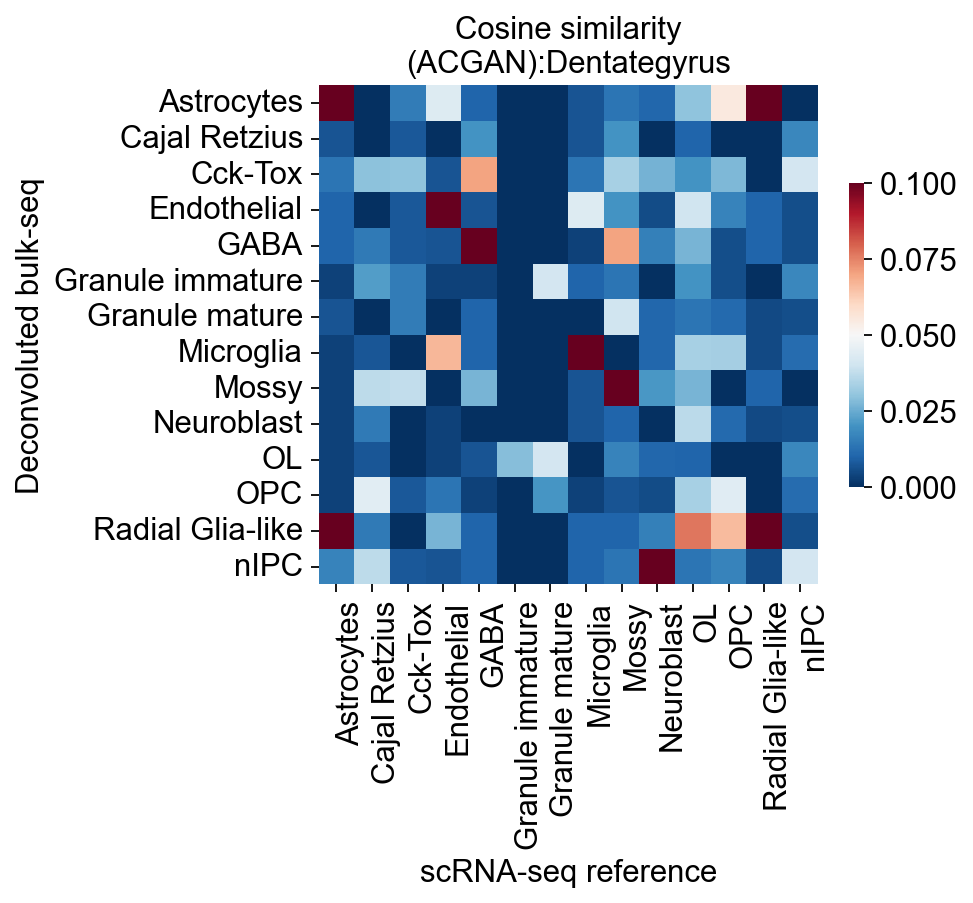

In [52]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(plot_data,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,vmax=0.1)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Cosine similarity\n(ACGAN):Dentategyrus")
plt.savefig('figures/heatmap_cossim_acgan_dg.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_cossim_acgan_dg.pdf',dpi=300,bbox_inches='tight')


In [53]:
adata3=test_adata[test_adata.obs['celltype']=='OPC']
adata3

View of AnnData object with n_obs × n_vars = 100 × 12953
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'celltype_colors', 'rank_genes_groups'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [54]:
bulktb.vae_model.single_data.obs['celltype']=bulktb.vae_model.single_data.obs['clusters']

In [55]:
import anndata
adata1=anndata.concat([bulktb.vae_model.single_data,adata3],
                     merge='same')
adata1

AnnData object with n_obs × n_vars = 3030 × 12953
    obs: 'celltype'

In [56]:
adata1.raw = adata1
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata1 = adata1[:, adata1.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [57]:
ov.pp.scale(adata1)
ov.pp.pca(adata1,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [58]:
adata1.obsm["X_mde"] = ov.utils.mde(adata1.obsm["scaled|original|X_pca"])
adata1

AnnData object with n_obs × n_vars = 3030 × 1644
    obs: 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

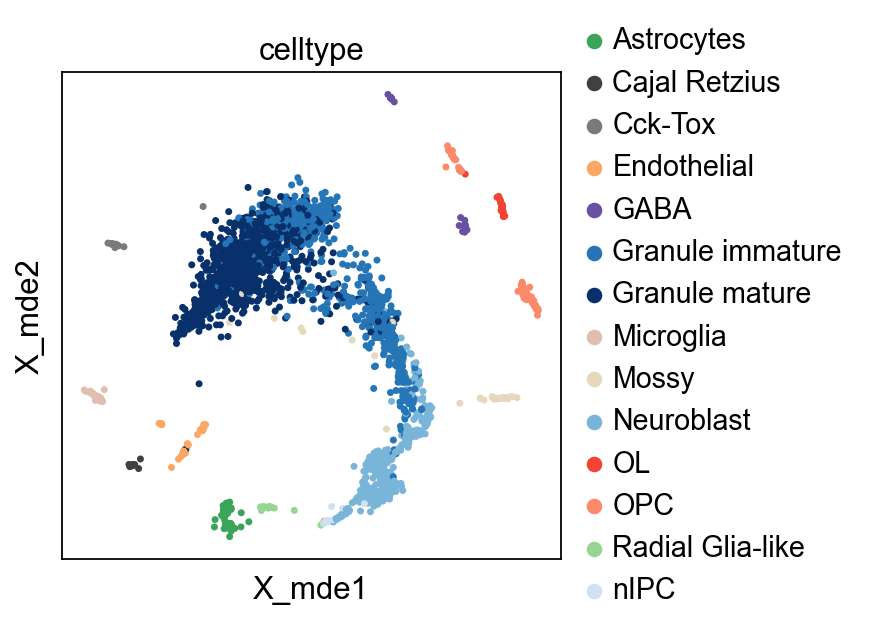

In [59]:
sc.pl.embedding(adata1,
                basis='X_mde',
           color=['celltype'],
           wspace=0.4,palette=adata.uns['clusters_colors'].tolist())

In [60]:
adata2=bulktb.vae_model.single_data.copy()

In [61]:
adata2.raw = adata2
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata2 = adata2[:, adata2.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [62]:
ov.pp.scale(adata2)
ov.pp.pca(adata2,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [63]:
adata2.obsm["X_mde"] = ov.utils.mde(adata2.obsm["scaled|original|X_pca"])
adata2

AnnData object with n_obs × n_vars = 2930 × 2254
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_umap', 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'ambiguous', 'spliced', 'unspliced', 'scaled', 'lognorm'

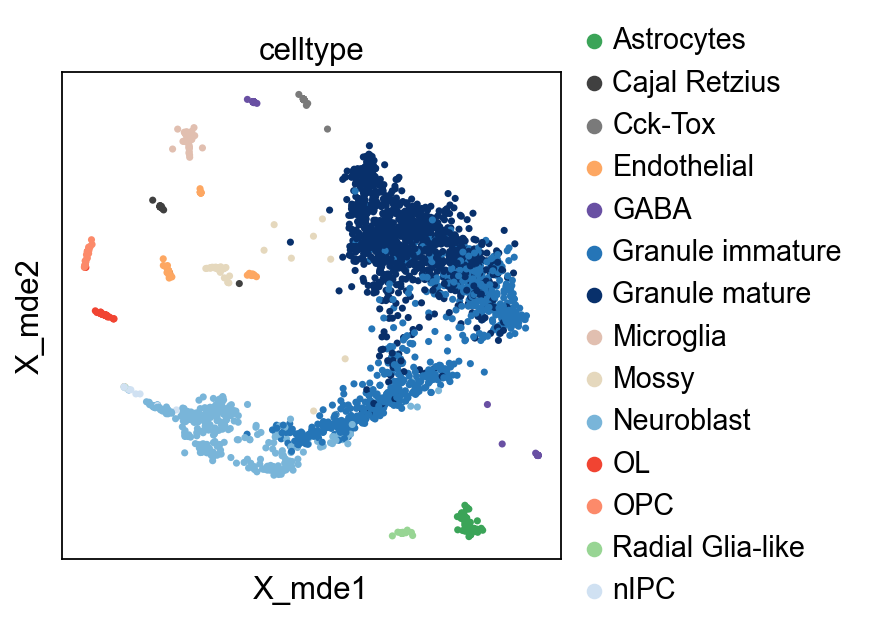

In [64]:
sc.pl.embedding(adata2,
                basis='X_mde',
           color=['celltype'],
           wspace=0.4,palette=adata.uns['clusters_colors'].tolist())

In [65]:
v0 = ov.single.pyVIA(adata=adata2,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['nIPC'],
                    dataset='group')
v0.run()

2023-10-05 15:20:04.095683	Running VIA over input data of 2930 (samples) x 50 (features)
2023-10-05 15:20:04.095714	Knngraph has 15 neighbors
2023-10-05 15:20:04.970310	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 39.6 % of edges. 
2023-10-05 15:20:04.978484	Number of connected components used for clustergraph  is 1
2023-10-05 15:20:05.018637	Commencing community detection
2023-10-05 15:20:05.156610	Finished running Leiden algorithm. Found 623 clusters.
2023-10-05 15:20:05.157304	Merging 593 very small clusters (<10)
2023-10-05 15:20:05.161365	Finished detecting communities. Found 52 communities
2023-10-05 15:20:05.161504	Making cluster graph. Global cluster graph pruning level: 0.15
2023-10-05 15:20:05.165578	Graph has 1 connected components before pruning
2023-10-05 15:20:05.167447	Graph has 15 connected components after pruning
2023-10-05 15:20:05.176013	Graph has 1 connected components after reconnecting
2023-10-05 15:20:05.176551	1.2% links tr

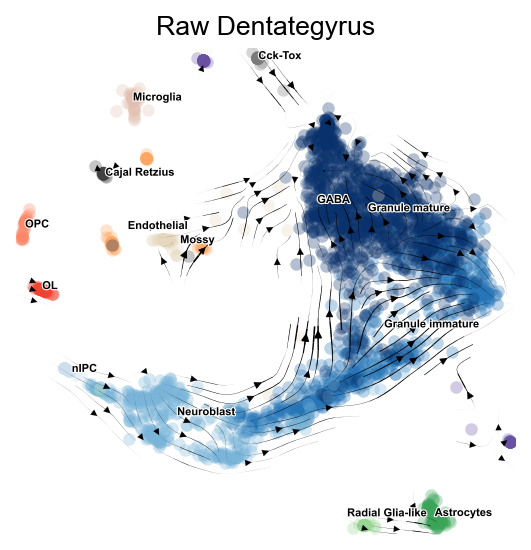

In [66]:
import matplotlib.pyplot as plt
fig,ax=v0.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Raw Dentategyrus',fontsize=12)
plt.savefig('figures/via_dg_raw1.png',dpi=300,bbox_inches='tight')

In [67]:
v0.get_pseudotime(adata2)
sc.pp.neighbors(adata2,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata2,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [68]:
raw_transitions=pd.DataFrame(adata2.uns['paga']['transitions_confidence'].toarray(),
            index=adata2.obs['celltype'].cat.categories,
            columns=adata2.obs['celltype'].cat.categories)

In [69]:
raw_transitions.loc['nIPC','OPC']

0.0

In [70]:
v1 = ov.single.pyVIA(adata=adata1,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['nIPC'],
                     #jac_std_global=0.01,
                    dataset='group')

v1.run()

2023-10-05 15:20:45.400889	Running VIA over input data of 3030 (samples) x 50 (features)
2023-10-05 15:20:45.401215	Knngraph has 15 neighbors
2023-10-05 15:20:46.537498	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 39.1 % of edges. 
2023-10-05 15:20:46.545754	Number of connected components used for clustergraph  is 1
2023-10-05 15:20:46.585332	Commencing community detection
2023-10-05 15:20:46.729897	Finished running Leiden algorithm. Found 759 clusters.
2023-10-05 15:20:46.730627	Merging 729 very small clusters (<10)
2023-10-05 15:20:46.736568	Finished detecting communities. Found 34 communities
2023-10-05 15:20:46.736711	Making cluster graph. Global cluster graph pruning level: 0.15
2023-10-05 15:20:46.740784	Graph has 1 connected components before pruning
2023-10-05 15:20:46.742750	Graph has 14 connected components after pruning
2023-10-05 15:20:46.749722	Graph has 1 connected components after reconnecting
2023-10-05 15:20:46.750105	0.0% links tr

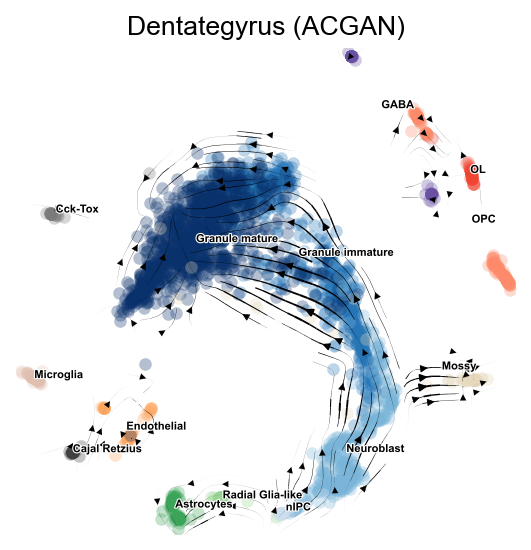

In [71]:
import matplotlib.pyplot as plt
fig,ax=v1.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Dentategyrus (ACGAN)',fontsize=12)
plt.savefig('figures/via_dg_acgan.png',dpi=300,bbox_inches='tight')

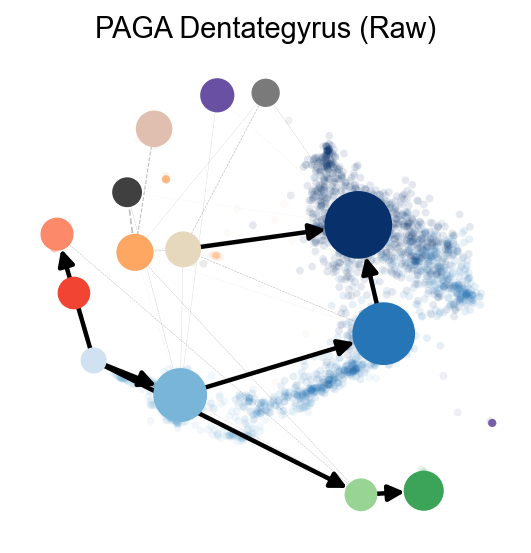

In [84]:
ov.utils.plot_paga(adata2,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)
plt.title('PAGA Dentategyrus (Raw)',fontsize=13)
plt.savefig('figures/paga_dg_raw.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/paga_dg_raw.pdf',dpi=300,bbox_inches='tight')

In [73]:
v1.get_pseudotime(adata1)
sc.pp.neighbors(adata1,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata1,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [74]:
after_transitions=pd.DataFrame(adata1.uns['paga']['transitions_confidence'].toarray(),
            index=adata1.obs['celltype'].cat.categories,
            columns=adata1.obs['celltype'].cat.categories)

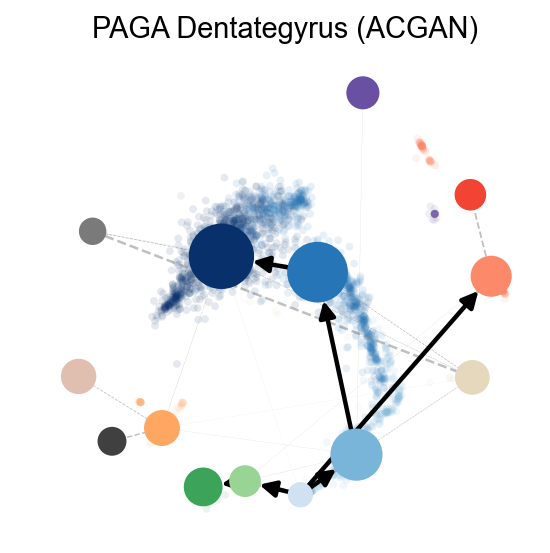

In [75]:
ov.utils.plot_paga(adata1,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)
plt.title('PAGA Dentategyrus (ACGAN)',fontsize=13)
plt.savefig('figures/paga_dg_acgan.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/paga_dg_acgan.pdf',dpi=300,bbox_inches='tight')

(0.0, 1.0)

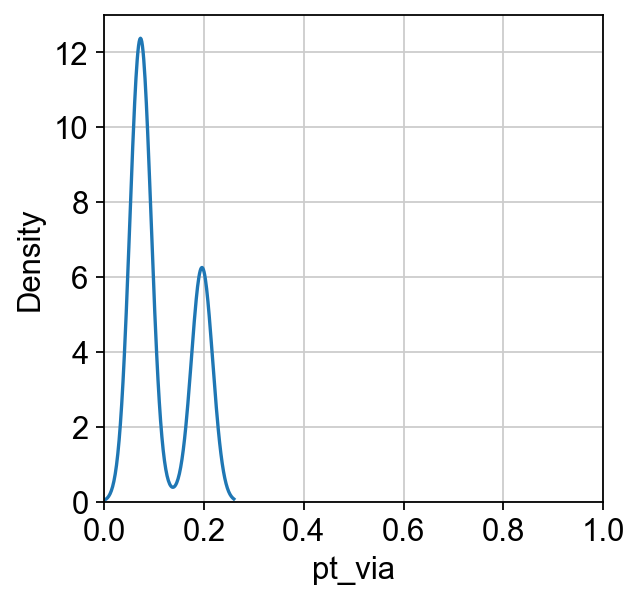

In [76]:
import seaborn as sns
sns.kdeplot(adata1.obs.loc[adata1.obs['celltype']=='OPC'],x='pt_via')
plt.xlim(0,1)

In [77]:
np.var(adata1.obs.loc[adata1.obs['celltype']=='OPC','pt_via'])

0.0033641781333378197

(0.0, 1.0)

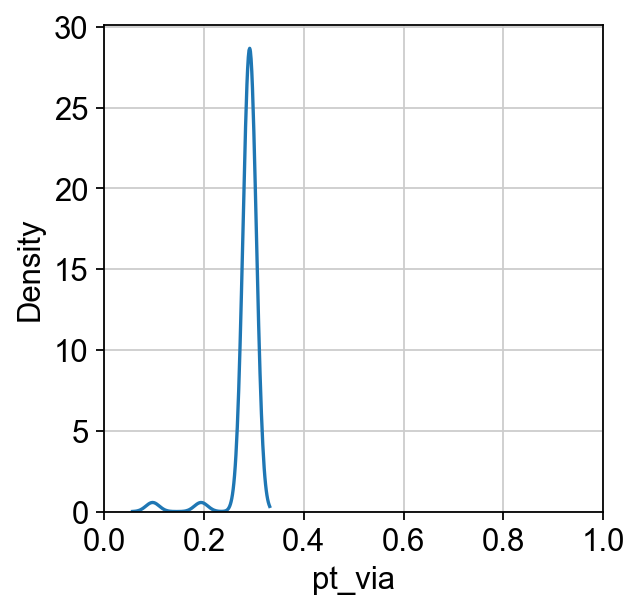

In [78]:
import seaborn as sns
sns.kdeplot(adata2.obs.loc[adata2.obs['celltype']=='OPC'],x='pt_via')
plt.xlim(0,1)

In [79]:
np.var(adata2.obs.loc[adata2.obs['celltype']=='OPC','pt_via'])

0.0008610680040077388

In [80]:
res_dict={}

#Cor:exp
# 计算对角线均值
diagonal_mean = np.trace(cor_pd.values) / len(cor_pd)
# 计算非对角线均值
non_diagonal_mean = (np.sum(cor_pd.values) - np.trace(cor_pd.values)) / (len(cor_pd)**2 - len(cor_pd))

res_dict['Cor_mean']=diagonal_mean
res_dict['non_Cor_mean']=non_diagonal_mean

#Cos:gene
# 计算对角线均值
diagonal_mean = np.trace(plot_data.values) / len(plot_data)

# 计算非对角线均值
non_diagonal_mean = (np.sum(plot_data.values) - np.trace(plot_data.values)) / (len(plot_data)**2 - len(plot_data))

res_dict['Cos_mean']=diagonal_mean
res_dict['non_Cos_mean']=non_diagonal_mean

#raw:trans
res_dict['Trans_raw']=raw_transitions.loc['OPC'].max()
res_dict['Trans_after']=after_transitions.loc['OPC'].max()


#Variance
res_dict['Var_raw']=np.var(adata2.obs.loc[adata2.obs['celltype']=='OPC','pt_via'])
res_dict['Var_after']=np.var(adata1.obs.loc[adata1.obs['celltype']=='OPC','pt_via'])


In [81]:
res_dict

{'Cor_mean': 0.7447424706163023,
 'non_Cor_mean': 0.5737731983230978,
 'Cos_mean': 0.10380949917187746,
 'non_Cos_mean': 0.015533761316587154,
 'Trans_raw': 0.012605069833265089,
 'Trans_after': 0.016074207762156765,
 'Var_raw': 0.0008610680040077388,
 'Var_after': 0.0033641781333378197}

In [82]:
import pickle
with open('result/metric_acgan_dg.pkl','wb') as f:
    pickle.dump(res_dict,f)

In [83]:
with open('result/metric_acgan_dg.pkl','rb') as f:
    res_dict=pickle.load(f)
res_dict

{'Cor_mean': 0.7447424706163023,
 'non_Cor_mean': 0.5737731983230978,
 'Cos_mean': 0.10380949917187746,
 'non_Cos_mean': 0.015533761316587154,
 'Trans_raw': 0.012605069833265089,
 'Trans_after': 0.016074207762156765,
 'Var_raw': 0.0008610680040077388,
 'Var_after': 0.0033641781333378197}